In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt
import random

# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.18.0


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Original x_train shape: (60000, 28, 28, 1)
Original x_test shape: (10000, 28, 28, 1)


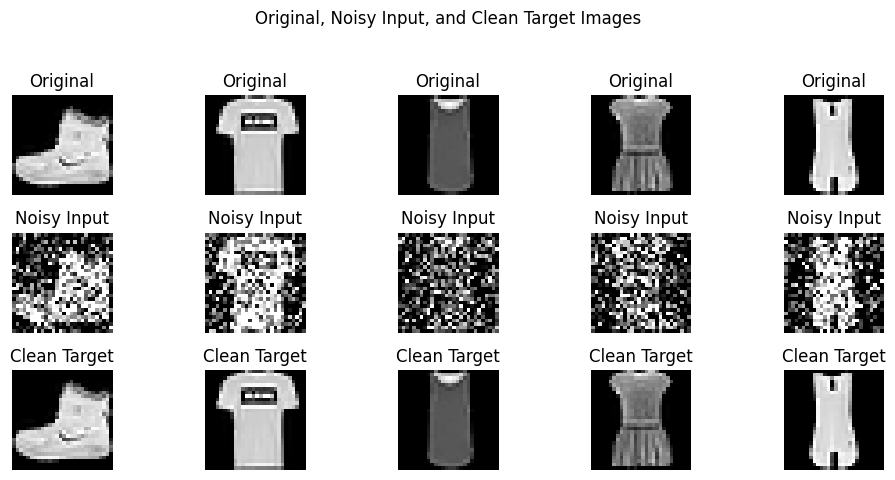

In [ ]:
# --- 1. Load and Preprocess Data ---
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize images to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape to add channel dimension (28, 28, 1)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(f"Original x_train shape: {x_train.shape}")
print(f"Original x_test shape: {x_test.shape}")

# Function to add random noise to images
def add_noise(images, noise_factor=0.2):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.) # Clip values to [0, 1]
    return noisy_images

noise_factor = 0.5 # Increased noise factor for clearer denoising
x_train_noisy = add_noise(x_train, noise_factor)
x_test_noisy = add_noise(x_test, noise_factor)

# Display some original, noisy, and clean images
plt.figure(figsize=(10, 5))
for i in range(5):
    # Original
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Noisy
    plt.subplot(3, 5, i + 6)
    plt.imshow(x_train_noisy[i].squeeze(), cmap='gray')
    plt.title("Noisy Input")
    plt.axis('off')

    # Clean (target)
    plt.subplot(3, 5, i + 11)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title("Clean Target")
    plt.axis('off')
plt.suptitle("Original, Noisy Input, and Clean Target Images")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# --- 2. Build the Encoder ---
def build_encoder(input_shape=(28, 28, 1), latent_dim=64):
    encoder_input = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x) # Output: (14, 14, 32)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x) # Output: (7, 7, 64)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x) # Output: (7, 7, 128)

    # Flatten for dense layer and then reshape to a 'bottleneck' 2D representation for visualization
    # We choose 4x4x8 as a bottleneck that is easily visualizable, making latent_dim = 4*4*8 = 128
    # The actual latent_dim is the number of units in the final dense layer before reshaping.
    volume_size_before_bottleneck = x.shape[1] * x.shape[2] * x.shape[3]
    print(f"Shape before bottleneck dense layer: {x.shape}") # Should be (None, 7, 7, 128)

    # Let's flatten and then have a dense layer that outputs `latent_dim` units
    # For visualization, we'll reshape this `latent_dim` later if it's not already a 2D feature map.
    flattened = layers.Flatten()(x)
    latent_representation = layers.Dense(latent_dim, activation='relu', name='latent_space')(flattened)

    encoder = models.Model(encoder_input, latent_representation, name='encoder')
    return encoder

latent_dimension = 128 # The size of our compressed representation
encoder = build_encoder(latent_dim=latent_dimension)
encoder.summary()

# --- 3. Build the Decoder ---
def build_decoder(latent_dim=64, output_shape=(28, 28, 1)):
    decoder_input = layers.Input(shape=(latent_dim,))

    # We need to reshape the latent_dim vector back to a 2D feature map that matches
    # the last convolutional layer output size in the encoder before its Flatten layer.
    # The encoder's last Conv2D output was (7, 7, 128). So, we'll reshape to that.
    # We need to ensure that `latent_dim` is a multiple of 7*7*128 if we want a direct reshape.
    # However, it's more common to have a Dense layer followed by a Reshape.

    # If latent_dim is 128, and our encoder's last conv layer output was (7, 7, 128)
    # this means the `latent_dim` represents the flattened output of some layer
    # Let's make our latent_dim suitable for reshaping into a feature map for the decoder.
    # The final Conv2D layer in the encoder has 128 filters, and its output is 7x7.
    # So, the size *before* flattening is 7 * 7 * 128 = 6272.
    # If latent_dim is smaller, say 64 or 128, then we need a Dense layer to expand it.

    # Let's assume the bottleneck is 'latent_dim' and we need to upsample from there.
    # A common strategy is to start with a dense layer that outputs the size of the feature map
    # just before the first upsampling (transpose conv) layer in the decoder.
    # In our case, the encoder's last max pooling gives (7, 7, 64). Let's base our decoder
    # entry point on reshaping to (7, 7, some_channel_size).

    # We'll make the latent_dim map to a dense layer that outputs the same dimension as the
    # encoder's last output before flattening, which was (7*7*128)
    initial_dense_units = 7 * 7 * 128 # This matches the encoder's last conv layer's output volume
    x = layers.Dense(initial_dense_units, activation='relu')(decoder_input)
    x = layers.Reshape((7, 7, 128))(x) # Reshape to the spatial dimensions of the last encoder conv output

    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x) # Output: (14, 14, 64)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(x) # Output: (28, 28, 32)

    decoder_output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) # Output: (28, 28, 1)

    decoder = models.Model(decoder_input, decoder_output, name='decoder')
    return decoder

decoder = build_decoder(latent_dim=latent_dimension)
decoder.summary()

Shape before bottleneck dense layer: (None, 7, 7, 128)


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 128)            │       802,944 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 895,616 (3.42 MB)

 Trainable params: 895,616 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 64)       │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 14, 14, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 947,809 (3.62 MB)

 Trainable params: 947,809 (3.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- 4. Build the Autoencoder Model ---
class Autoencoder(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        encoded = self.encoder(inputs)
        reconstructed = self.decoder(encoded)
        return reconstructed

autoencoder = Autoencoder(encoder, decoder)
autoencoder.compile(optimizer='adam', loss='mse') # Using Mean Squared Error for reconstruction loss
autoencoder.summary()

# --- 5. Train the Autoencoder ---
history_losses = []

class LossHistory(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        history_losses.append(logs['loss'])

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10, # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored metric.
)

loss_history_callback = LossHistory()

epochs = 100 # Increased epochs for better training
batch_size = 128

print("\nStarting training...")
history = autoencoder.fit(
    x_train_noisy, x_train, # Input is noisy, target is clean
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stopping, loss_history_callback]
)
print("Training finished.")

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ (None, 128)            │       895,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │       947,809 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,843,425 (7.03 MB)

 Trainable params: 1,843,425 (7.03 MB)

 Non-trainable params: 0 (0.00 B)


Starting training...
Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 0.0647 - val_loss: 0.0220
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.0208 - val_loss: 0.0183
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0177 - val_loss: 0.0166
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0163 - val_loss: 0.0157
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0154 - val_loss: 0.0157
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0148 - val_loss: 0.0149
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0142 - val_loss: 0.0145
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0138 - val_loss: 0.0142
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0134 - val_loss: 0.0140
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0131 - val_loss: 0.0138
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0128 - val_loss: 0.0137
Ep

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


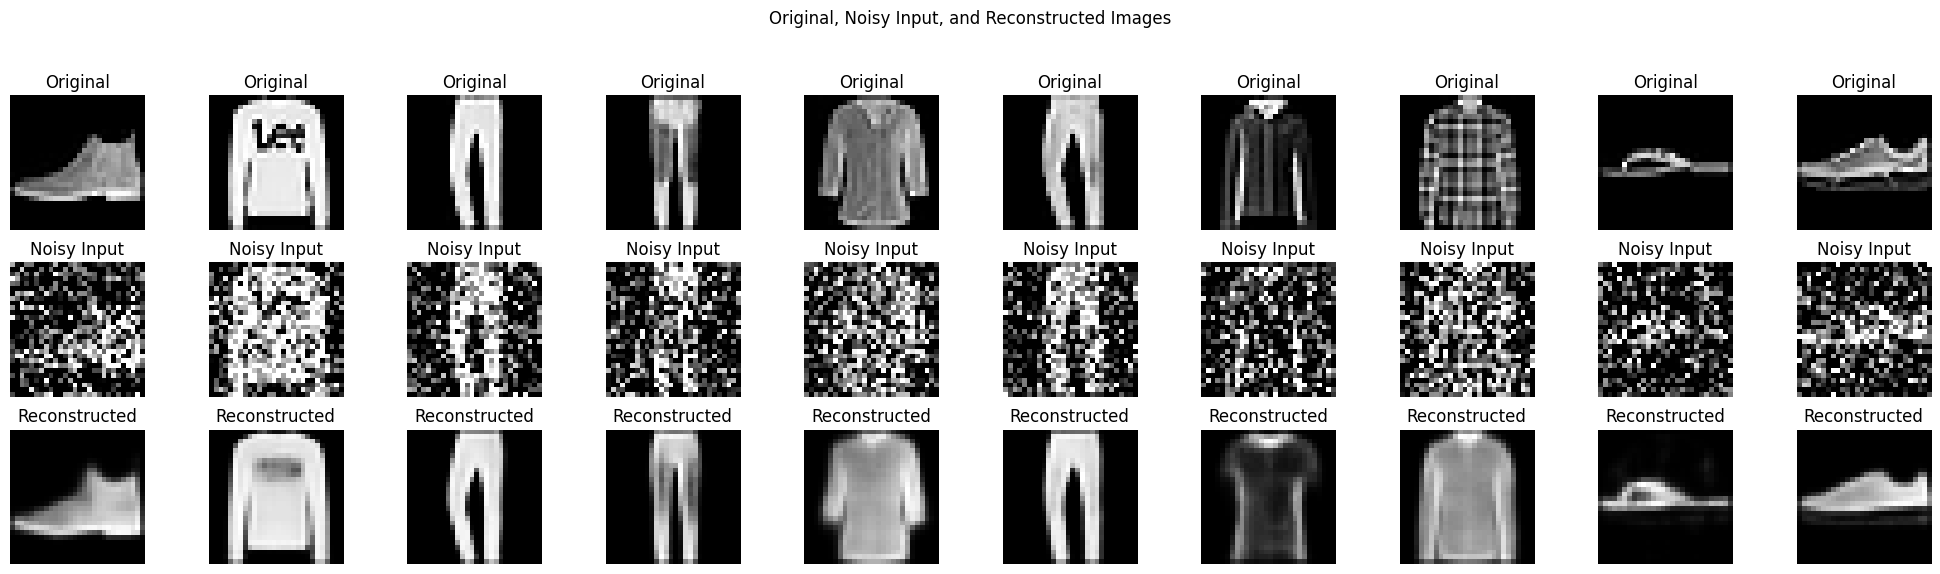

In [ ]:
# --- 6. Visualize Results ---

# Get reconstructed images from the test set
reconstructed_images = autoencoder.predict(x_test_noisy)

# Plot original, noisy, and reconstructed images
n = 10 # Number of images to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Noisy input
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray')
    plt.title("Noisy Input")
    plt.axis('off')

    # Reconstructed image
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(reconstructed_images[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.suptitle("Original, Noisy Input, and Reconstructed Images")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


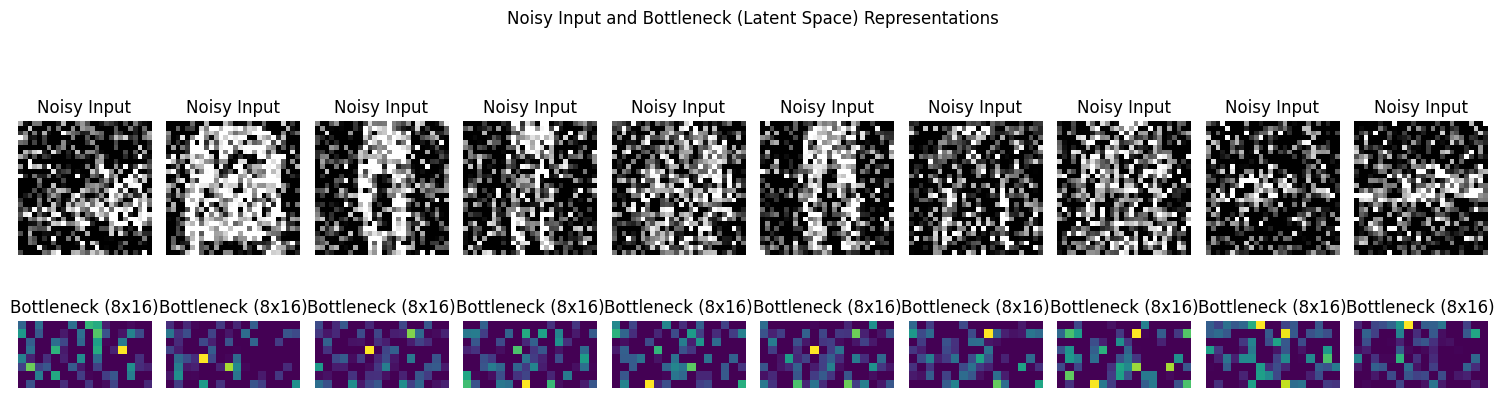

In [ ]:
# --- Bottleneck Visualization ---
# Get the latent space representation (bottleneck) for some test images
encoder_output = encoder.predict(x_test_noisy[:n]) # Get the output of the encoder for 'n' test images

plt.figure(figsize=(15, 5))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray')
    plt.title("Noisy Input")
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)

    # Reshape the 1D latent vector into a 2D feature map for visualization.
    # Since our latent_dim is 128, we can reshape it to, for example, 8x16 or 16x8
    # or even 4x4x8 if we want to show multiple channels in a grid.
    # For simplicity, let's visualize it as a 1D intensity plot or a small square.

    # If we reshape to a square, e.g., sqrt(128) is not an integer.
    # Let's try reshaping to (4, 32) or (8, 16) or just a 1D plot.

    # Option 1: Treat as a 1D vector and plot intensity
    # plt.imshow(encoder_output[i].reshape(1, -1), cmap='viridis', aspect='auto') # Reshape to 1xlatent_dim
    # plt.title("Bottleneck (1D)")
    # plt.axis('off')

    # Option 2: Reshape to a small 2D grid if possible (e.g., 8x16 for 128)
    if latent_dimension == 128:
        # We can reshape 128 into 8x16 or 4x32 or 2x64. Let's pick 8x16
        # for a more square-like appearance.
        bottleneck_2d = encoder_output[i].reshape((8, 16))
        plt.imshow(bottleneck_2d, cmap='viridis')
        plt.title("Bottleneck (8x16)")
    else:
        # Fallback for other latent dimensions: just plot as 1D
        plt.imshow(encoder_output[i].reshape(1, -1), cmap='viridis', aspect='auto')
        plt.title("Bottleneck (1D)")

    plt.axis('off')

plt.suptitle("Noisy Input and Bottleneck (Latent Space) Representations")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

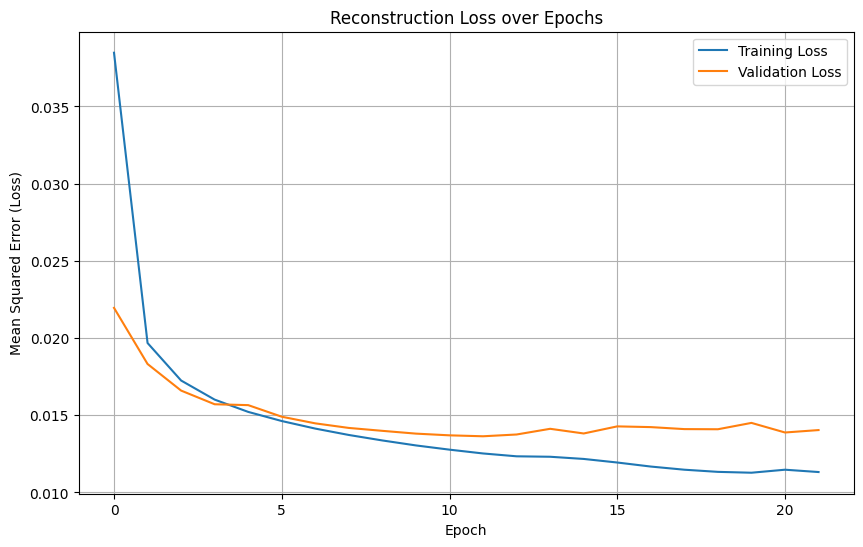

In [ ]:
# --- Reconstruction Loss Graph ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Reconstruction Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (Loss)')
plt.legend()
plt.grid(True)
plt.show()